In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from config import password

In [57]:
# Connect to PostgreSQL database
rds_connection_string = f'postgres:" + password + "@localhost:5432/names'
engine = create_engine(f'postgresql://{rds_connection_string}')

# Automap and reflect
base = automap_base()
base.prepare(engine, reflect=True)
names = base.classes.name_table

# Create session
session = Session(engine)

In [58]:
# Print columns
inspector = inspect(engine)
columns = inspector.get_columns('name_table')
for column in columns:
    print(column["name"],column["type"])

id INTEGER
name VARCHAR(30)
year INTEGER
gender VARCHAR(1)
count INTEGER


In [59]:
## Quick functions 
def barchart(x, y, title):
    axis = np.arange(len(x))
    plt.bar(x, y, color='cornflowerblue')
    plt.xticks(axis, x, rotation=45)
    plt.title(title)
    plt.show()

## Most popular names

#### Top names overall

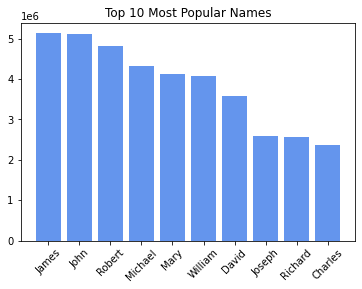

In [95]:
# Top 10 most popular names 
top_names = session.query(names.name, func.sum(names.count))\
            .group_by(names.name)\
            .order_by(func.sum(names.count).desc()).limit(10).all()

# Convert to dataframe
top_names_df = pd.DataFrame(top_names, columns=columns)

# Show as barchart
barchart(top_names_df.Name, top_names_df.Count, 'Top 10 Most Popular Names')

#### Top Names By Gender

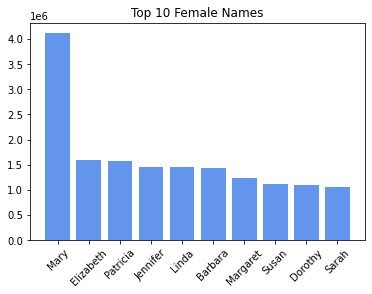

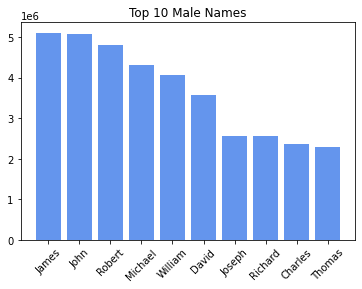

In [93]:
# Top 10 names by gender
top_female_names = session.query(names.name, func.sum(names.count))\
                .filter(names.gender == 'F')\
                .group_by(names.name).order_by(func.sum(names.count).desc()).limit(10).all()

top_male_names = session.query(names.name, func.sum(names.count))\
                .filter(names.gender == 'M')\
                .group_by(names.name).order_by(func.sum(names.count).desc()).limit(10).all()

# Convert to dataframe
columns = ['Name','Count']
female_names_df = pd.DataFrame(top_female_names, columns=columns)
male_names_df = pd.DataFrame(top_male_names, columns=columns)

# Barcharts 
barchart(female_names_df.Name, female_names_df.Count, 'Top 10 Female Names')
barchart(male_names_df.Name, male_names_df.Count, 'Top 10 Male Names')

### Top names in the last 10 years
Overall

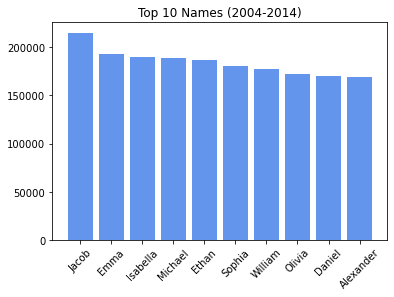

In [87]:
# Find the most recent date in the data set.
recent_year = session.query(names.year).order_by(names.year.desc()).first()
recent_year = recent_year[0]

# Calculate 10 years prior 
decade = recent_year - 10

# Query last 10 years 
decade_query = session.query(names.name, func.sum(names.count))\
                .filter(names.year > decade)\
                .group_by(names.name).order_by(func.sum(names.count).desc()).limit(10).all()

# Convert to dataframe
decade_df = pd.DataFrame(decade_query,columns=['Name', 'Count'])

# Show as barchart 
barchart(decade_df.Name, decade_df.Count, 'Top 10 Names (2004-2014)')

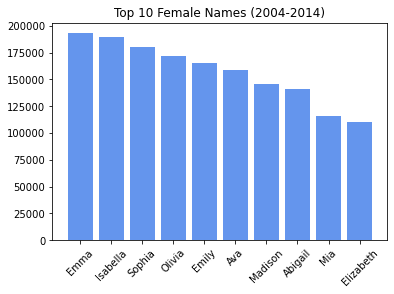

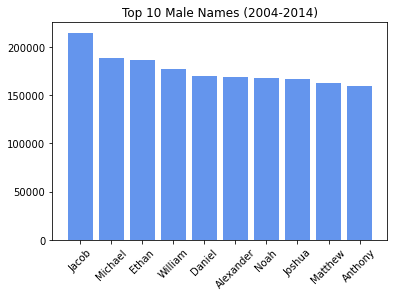

In [92]:
# Query last decade filtered by gender
decade_query_female = session.query(names.name, func.sum(names.count))\
                .filter(names.year > decade, names.gender == 'F')\
                .group_by(names.name).order_by(func.sum(names.count).desc()).limit(10).all()

decade_query_male = session.query(names.name, func.sum(names.count))\
                .filter(names.year > decade, names.gender == 'M')\
                .group_by(names.name).order_by(func.sum(names.count).desc()).limit(10).all()

# Convert to dataframe
decade_female_df = pd.DataFrame(decade_query_female, columns=columns)
decade_male_df = pd.DataFrame(decade_query_male, columns=columns)

# Barcharts 
barchart(decade_female_df.Name, decade_female_df.Count, 'Top 10 Female Names (2004-2014)')
barchart(decade_male_df.Name, decade_male_df.Count, 'Top 10 Male Names (2004-2014)')

## Popularity over time 
* Uses relative popularity (due to changes in population over time)

In [158]:
# List of most popular names 
names_list = top_names_df.Name

# Filter for these names
top_names_by_year = session.query(names.name, names.year, names.count, names.gender)\
                    .filter(names.name.in_(names_list)).all()
# Convert to dataframe
names_by_year_df = pd.DataFrame(top_names_by_year, columns=['Name','Year','Count','Gender'])
names_by_year_df = names_by_year_df.sort_values(by=['Name','Year']).reset_index(drop=True)

# Pivot table (Uses total - does not group by gender)
names_by_year_pivot = pd.pivot_table(names_by_year_df, values=['Count'], aggfunc='sum', index=['Name','Year'])

* Relative popularity - uses the count / total names for that year to account for changes in population

In [160]:
# Sorts by name and year (combines unisex names)
name_df = names_by_year_df.groupby(["Name", "Year"]).sum().reset_index()

# Relative popularity (For each name: Name count / Total annual count) 
def relative_popularity(df):
    for i, row in df.iterrows():
        count = row['Count']
        year = row['Year']
        year_total = df.loc[df['Year'] == year, 'Count'].sum()
        df.loc[i,'Relative Popularity'] = count / year_total
relative_popularity(name_df)
name_df

,Name,Year,Count,Relative Popularity
0,Charles,1880,5359,0.119936
1,Charles,1881,4653,0.114268
2,Charles,1882,5115,0.113109
3,Charles,1883,4844,0.115136
4,Charles,1884,4821,0.106577
...,...,...,...,...
1345,William,2010,17053,0.157052
1346,William,2011,17342,0.166152
1347,William,2012,16863,0.166141
1348,William,2013,16584,0.166028
